# Monk1 
Grid Search for Monk1 dataset model selection


In [2]:
from exclusiveAI.components.Validation.HoldOut import parallel_hold_out, hold_out
from exclusiveAI.ConfiguratorGen import ConfiguratorGen
from exclusiveAI.datasets.monk import read_monk1
from exclusiveAI.utils import one_hot_encoding
from exclusiveAI.Composer import Composer
from tqdm import tqdm
import pandas as pd
import numpy as np
from exclusiveAI.utils import plot_history
import os, json

#### Read Monk1 dataset 

In [3]:
file_path = "MLCup/Data/training_data_split.json"
# Load training and test data from the JSON file
with open(file_path, 'r') as jsonfile:
    data_dict = json.load(jsonfile)

training_data = np.array(data_dict['training_data'])
training_labels = np.array(data_dict['training_labels'])
test_data = np.array(data_dict['test_data'])
test_labels = np.array(data_dict['test_labels'])
train_idx = np.array(data_dict['train_idx'])
test_idx = np.array(data_dict['test_idx'])

In [ ]:
def read_json_files(my_dir_path):
        data = pd.DataFrame()
        for file in os.listdir(my_dir_path):
            if file.endswith('.json'):
                with open(os.path.join(my_dir_path, file), 'r') as f:
                    my_data = [data['0'] for data in json.load(f).values()]
                    data = pd.concat([data,  pd.DataFrame(my_data)], ignore_index=True, axis=0)
        return data
batch_size = 32
epochs = 200

if not os.path.exists('MLCup_1output_models_configurations.json'):
    dir_path = "MLCup/"
    
    all_json_data = read_json_files(dir_path)
    regularizations = all_json_data['regularization'].unique().tolist()
    learning_rates = all_json_data['learning_rate'].unique().tolist()
    momentums = all_json_data['momentum'].unique().tolist()
    num_of_layers = all_json_data['num_layers'].unique().tolist()
    num_of_units = set([unit1 for unit in all_json_data['num_of_units'] for unit1 in unit])
    initializers = all_json_data['initializers'].unique().tolist()
    activations = ["sigmoid", 'tanh']
    
    myConfigurator = ConfiguratorGen(random=False, learning_rates=learning_rates, regularizations=regularizations,
                                     loss_function=['mse'], optimizer=['sgd'],
                                     activation_functions=activations,
                                     number_of_units=num_of_units, number_of_layers=num_of_layers,
                                     momentums=momentums, initializers=initializers,
                                     input_shapes=training_data.shape,
                                     verbose=False, nesterov=True, number_of_initializations=2, outputs=3,
                                     callbacks=["earlystopping"], output_activation='linear', show_line=False,
                                     ).get_configs()
    print(len(myConfigurator))
    
    configs=[]
    if __name__ == '__main__':
        configs.append(
            parallel_hold_out(myConfigurator, training=training_data, training_target=training_labels, epochs=epochs,
                              batch_size=batch_size, all_models=True, num_models=100, workers=8
                              ))
    
        configs = pd.DataFrame(configs)
        # Save as json
        configs.to_json('monk1_models_configs.json')
else: 
    with open('monk1_models_configs.json', 'r') as f:
        configs = [data['0'] for data in json.load(f).values()]

Appending: 100%|██████████| 4/4 [00:00<00:00, 53946.03it/s]


In [6]:
models = []
with tqdm(total=len(configs)) as pbar:
    for config in configs:
        model = Composer(config=config).compose()
        model.train(inputs=training_data, input_label=training_labels, epochs=epochs, batch_size=batch_size, name=config['model_name'], disable_line=True)
        test_val = model.evaluate(input=test_data, input_label=test_labels)
        models.append((model.get_last()['mse'], np.std(np.array(model.history['mse'])), model.get_last()['binary_accuracy'], test_val[0], test_val[1], model.curr_epoch, model.history['mee'], Composer(config=config).compose(), config, config['num_layers'], config['num_of_units'], config['model_name']))
        pbar.update(1)

# Convert the list of tuples to a DataFrame with one column for each element in the tuple
df = pd.DataFrame(models, columns=['Score', 'History_Std', 'Accuracy', 'Test_Score', 'Test_Accuracy', 'Trained_Epochs', 'History', 'Model', 'Config', 'Num_Layers', 'Num_of_Units', 'Name'])

100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


In [7]:
# Sort the DataFrame by the first element in the tuple (column 'Value')

df_sorted = df.sort_values(by=['Num_Layers', 'Score', 'Test_Score', 'History_Std'])
df_sorted = df_sorted[df_sorted['Accuracy'] >= 1]
df_sorted = df_sorted[df_sorted['Test_Accuracy'] >= 1]
# df_sorted = df_sorted[df_sorted['History_Std'] <= 0.11]
# df_sorted = df_sorted[df_sorted['Num_Layers'] <= 1]
# df_sorted['Num_of_Units'] = [value[0] for value in df_sorted['Num_of_Units']]
# df_sorted = df_sorted[df_sorted['Num_of_Units'] == 4]
histories = {row[0]: row[1] for row in df_sorted[['Name', 'History']].values}
df_sorted

,Score,History_Std,Accuracy,Test_Score,Test_Accuracy,Trained_Epochs,History,Model,Config,Num_Layers,Num_of_Units,Name
25,0.000606,0.057489,1.0,0.001311,1.0,174,"[0.5106228615618942, 0.5106198773796555, 0.499...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.54,...",1,[4],Model275535
99,0.000862,0.059811,1.0,0.001870,1.0,189,"[0.4987355484499011, 0.49548787993904925, 0.49...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.59,...",1,[4],Model228975
62,0.000872,0.070512,1.0,0.008728,1.0,180,"[0.503108555001753, 0.5039898160711347, 0.5028...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.51,...",1,[4],Model292494
5,0.000892,0.068875,1.0,0.002121,1.0,169,"[0.5124689422690679, 0.5136361362552122, 0.505...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.51,...",1,[3],Model292484
82,0.000939,0.062283,1.0,0.003837,1.0,191,"[0.5140676449372346, 0.5099551737406612, 0.500...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.6, ...",1,[4],Model239214
46,0.000944,0.066140,1.0,0.002632,1.0,166,"[0.5081545281451507, 0.5068804293238405, 0.502...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.56,...",1,[4],Model252815
37,0.000954,0.059761,1.0,0.001637,1.0,186,"[0.49202506477571667, 0.4926342658399116, 0.48...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.57,...",1,[4],Model260326
70,0.000961,0.059067,1.0,0.001406,1.0,189,"[0.5227170508635076, 0.5164845862481936, 0.500...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.54,...",1,[4],Model276006
76,0.001109,0.056830,1.0,0.001552,1.0,200,"[0.5053601062869364, 0.5021538044449594, 0.496...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.58,...",1,[4],Model244654
94,0.001227,0.058054,1.0,0.001775,1.0,200,"[0.5009246375729927, 0.49743860827794223, 0.49...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.59,...",1,[3],Model230252


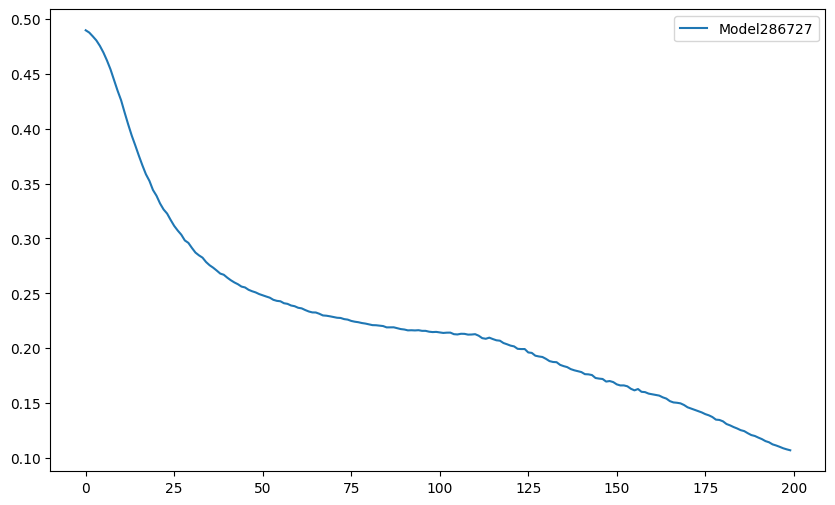

In [34]:
# plot_history(histories)

plot_history({"Model286727": histories['Model286727']})